# Make Panda Dataset

In [1]:
import cv2
from glob import glob
import numpy as np
import os
import json
import matplotlib.pyplot as plt
%matplotlib inline


# Unify some differences between VIA labeling Tool and COCO

In [3]:
COCO_INFO = {"year":2020,"version":"1","description":"Exported using VGG Image Annotator (http://www.robots.ox.ac.uk/~vgg/software/via/)","contributor":"","url":"http://www.robots.ox.ac.uk/~vgg/software/via/","date_created":"Fri Apr 17 2020 10:41:28 GMT+0800 (China Standard Time)"}
COCO_LICENSES = [{"id":1,"name":"Unknown","url":""}]

def transfer_via_to_coco(via_anno_file, image_dir, coco_anno_file):

    
    coco_annotation_dict = {}
    coco_annotation_dict["info"] = COCO_INFO
    coco_annotation_dict["licenses"] = COCO_LICENSES
    coco_annotation_dict["images"] = []
    coco_annotation_dict["annotations"] = []
    coco_annotation_dict["categories"] = [{"id":1, "name":"panda", "supercategory":"animal"}]
    

    with open(via_anno_file, 'r') as f:
        imgs_anns = json.load(f)
    
    annotation_idx = 0
    for image_idx, anno_dict in enumerate(imgs_anns.values()):
        #print(anno_dict)
        filename = anno_dict["filename"]
        regions = anno_dict["regions"]
        
        # parse images record, 
        # - keys: 
        #             id
        #          width
        #         height
        #      file_name
        #    license(id) 
        #  data_captured
        image_file = os.path.join(image_dir, filename)
        image = cv2.imread(image_file)
        height, width, _ = image.shape
        image_record = {"id": image_idx,
                       "width": width,
                       "height": height,
                       "file_name":filename,
                       "license":1,
                       "date_captured":""}
        coco_annotation_dict["images"].append(image_record)
        
        # parse annotations record from regions, 
        # - keys: 
        #       id, 
        #       image_id, 
        #       category_id, 
        #       segementation:[[x1,x2,..],[y1,y2,..]], 
        #       bbox:[(left_top_x, left_top_y, width, height)], 
        #       iscrowd: 0,1
        for i in range(len(regions)):
            region = regions[i]
            shape_attributes_dict = region["shape_attributes"]   # region's ploy points
            region_attributes_dict = region["region_attributes"] # region's label, such as panda
            #for shape_attribute, region_attribute in zip(shape_attributes_dict, region_attributes_dict):
            #    print('shape_attribute:', shape_attribute)
            all_points_x = shape_attributes_dict["all_points_x"]
            all_points_y = shape_attributes_dict["all_points_y"]

            #segmentation = [all_points_x, all_points_y]
            poly = [(x, y) for x, y in zip(all_points_x, all_points_y)]
            poly = [p for x in poly for p in x]
            
            
            bbox_lefttop_x = min(all_points_x)
            bbox_lefttop_y = min(all_points_y)
            bbox_width = max(all_points_x) - min(all_points_x)
            bbox_height = max(all_points_y) - min(all_points_y)
            bbox = [bbox_lefttop_x, bbox_lefttop_y, bbox_width, bbox_height]
            category_id = int(region_attributes_dict["object"]) # key 'object' is decided by you in VIA, can be any thing
            annotation_record = {"id":annotation_idx,
                                "image_id": image_idx,
                                "category_id":category_id,
                                "segmentation":[poly],
                                "bbox":bbox,
                                "area": bbox_height * bb
                                "iscrowd":0}
            coco_annotation_dict["annotations"].append(annotation_record)
            annotation_idx += 1

    with open(coco_anno_file, 'w') as f:
        json.dump(coco_annotation_dict, f)

for phase in ["train", "val"]:
    anno = "panda_coco/annotations/via_panda_{}.json".format(phase)
    image_dir = "panda_coco/{}".format(phase)
    output = "panda_coco/annotations/panda_{}.json".format(phase)
    transfer_via_to_coco(anno, image_dir, output)

# Model Settings

In [4]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import random

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import ColorMode

In [5]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("panda_train", {}, "panda_coco/annotations/panda_train.json", "panda_coco/train")
register_coco_instances("panda_val", {}, "panda_coco/annotations/panda_val.json", "panda_coco/val")

panda_metadata = MetadataCatalog.get("panda_train")
dataset_dicts = detectron2.data.datasets.load_coco_json(json_file='panda_coco/annotations/panda_train.json', image_root='./panda_coco/train', dataset_name='panda_train', extra_annotation_keys=None)

[04/17 23:59:47 d2.data.datasets.coco]: Loaded 120 images in COCO format from panda_coco/annotations/panda_train.json


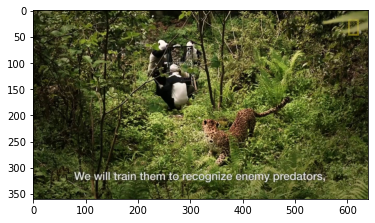

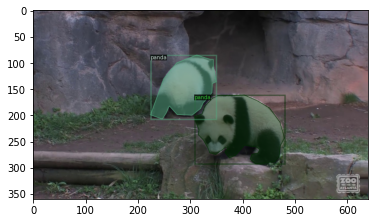

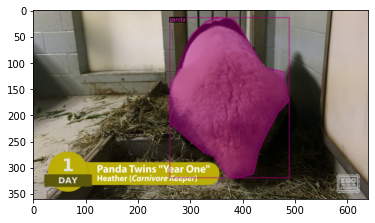

In [11]:
for i, d in enumerate(random.sample(list(dataset_dicts), 3)):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], 
                            metadata=panda_metadata, 
                            scale=0.5,
                            instance_mode=ColorMode.IMAGE_BW)
    vis = visualizer.draw_dataset_dict(d)
    image = vis.get_image()[:,:,::-1]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(i)
    plt.imshow(image)
    plt.show()

In [14]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x.yaml"))
cfg.DATASETS.TRAIN = ("panda_train",)
cfg.DATASETS.TEST = ("panda_val",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x.yaml")  # Let training initialize from model zoo
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1               # IMPORTANT HERE!  1 for panda
cfg.MODEL.ROI_HEADS.BATCH_SIZE_FOR_IMAGE = 512

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025   # pick a good LR
cfg.SOLVER.WARMUP_ITERS = 100  # warmup lr before iter < 100
cfg.SOLVER.GAMMA = 0.3
cfg.SOLVER.STEPS = (300, 400)
cfg.SOLVER.MAX_ITER = 500   # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset

cfg.INPUT.MAX_SIZE_TEST = 1280
cfg.INPUT.MAX_SIZE_TRAIN = 1280

In [15]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

[04/18 00:00:49 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

[04/18 00:00:49 d2.data.datasets.coco]: Loaded 120 images in COCO format from panda_coco/annotations/panda_train.json
[04/18 00:00:49 d2.data.build]: Removed 22 images with no usable annotations. 98 images left.
[04/18 00:00:49 d2.data.common]: Serializing 98 elements to byte tensors and concatenating them all ...
[04/18 00:00:49 d2.data.common]: Serialized dataset takes 0.05 MiB
[04/18 00:00:49 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1280, sample_style='choice'), RandomFlip()]
[04/18 00:00:49 d2.data.build]: Using training sampler TrainingSampler


'roi_heads.box_predictor.cls_score.weight' has shape (81, 2048) in the checkpoint but (2, 2048) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (2,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 2048) in the checkpoint but (4, 2048) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (4,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (80,) in the checkpoint but (1,) in the model! Skipped.


In [16]:
trainer.train()

[04/18 00:00:52 d2.engine.train_loop]: Starting training from iteration 0
[04/18 00:01:12 d2.utils.events]:  eta: 0:08:00  iter: 19  total_loss: 1.708  loss_cls: 0.582  loss_box_reg: 0.216  loss_mask: 0.689  loss_rpn_cls: 0.118  loss_rpn_loc: 0.082  time: 1.0103  data_time: 0.0103  lr: 0.000048  max_mem: 5068M
[04/18 00:01:32 d2.utils.events]:  eta: 0:07:34  iter: 39  total_loss: 1.405  loss_cls: 0.288  loss_box_reg: 0.233  loss_mask: 0.627  loss_rpn_cls: 0.119  loss_rpn_loc: 0.064  time: 0.9966  data_time: 0.0029  lr: 0.000098  max_mem: 5101M
[04/18 00:01:52 d2.utils.events]:  eta: 0:07:14  iter: 59  total_loss: 1.195  loss_cls: 0.196  loss_box_reg: 0.240  loss_mask: 0.517  loss_rpn_cls: 0.099  loss_rpn_loc: 0.080  time: 0.9938  data_time: 0.0028  lr: 0.000148  max_mem: 5101M
[04/18 00:02:12 d2.utils.events]:  eta: 0:06:56  iter: 79  total_loss: 1.030  loss_cls: 0.178  loss_box_reg: 0.248  loss_mask: 0.411  loss_rpn_cls: 0.088  loss_rpn_loc: 0.063  time: 0.9938  data_time: 0.0029  lr:

In [17]:
%load_ext tensorboard
%tensorboard --logdir output

Reusing TensorBoard on port 6006 (pid 7231), started 6:01:58 ago. (Use '!kill 7231' to kill it.)

# Inference & Evaluation trained model

## Inference

In [18]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg.DATASETS.TEST = ("panda_val",)
predictor = DefaultPredictor(cfg)

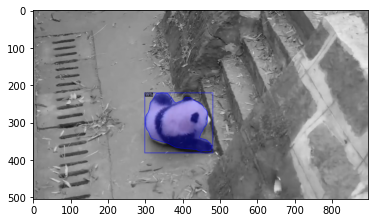

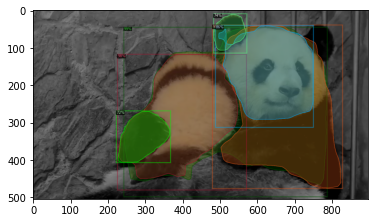

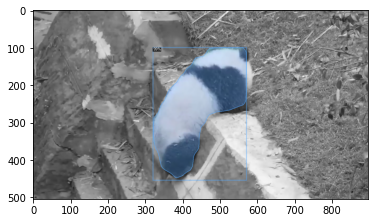

In [21]:
from detectron2.utils.visualizer import ColorMode
image_dirs = glob('./panda_coco/val/*.jpg')
metadata = MetadataCatalog.get("panda_val")
for i, image_dir in enumerate(random.sample(image_dirs, 3)):
    im = cv2.imread(image_dir)
    outputs = predictor(im)
    v = Visualizer(im[:,:,::-1],
                  metadata=metadata,
                  scale=0.7,
                  instance_mode=ColorMode.IMAGE_BW)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    image = v.get_image()[:,:,::-1]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(i)
    plt.imshow(image)
    plt.show()

## Evaluate

In [22]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("panda_val", cfg, False, output_dir='./output')
val_loader = build_detection_test_loader(cfg, "panda_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

[04/18 00:11:47 d2.data.datasets.coco]: Loaded 20 images in COCO format from panda_coco/annotations/panda_val.json
[04/18 00:11:47 d2.data.common]: Serializing 20 elements to byte tensors and concatenating them all ...
[04/18 00:11:47 d2.data.common]: Serialized dataset takes 0.01 MiB
[04/18 00:11:47 d2.evaluation.evaluator]: Start inference on 20 images
[04/18 00:11:49 d2.evaluation.evaluator]: Inference done 11/20. 0.1271 s / img. ETA=0:00:01
[04/18 00:11:50 d2.evaluation.evaluator]: Total inference time: 0:00:02.587517 (0.172501 s / img per device, on 1 devices)
[04/18 00:11:50 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.157087 s / img per device, on 1 devices)
[04/18 00:11:50 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/18 00:11:50 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[04/18 00:11:50 d2.evaluation.coco_evaluation]: Evaluating predictions ...
Loading and preparing results...
DO

KeyError: 'area'

# CHECK